<a href="https://www.kaggle.com/code/mustafakapici/heart-failure-prediction?scriptVersionId=182515506" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline

In [2]:
path = '/kaggle/input/predict-survival-of-patients-with-heart-failure/heart_failure_clinical_records_dataset.csv'
df = pd.read_csv(path)

In [3]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
df.shape

(299, 13)

In [5]:
#drop unnecessary columns
#df.drop(columns=['unnecessary'], inplace=True)

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [8]:
df.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [9]:
df.dropna()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [10]:
target_feature = 'DEATH_EVENT'

categorical_features = ['anaemia','diabetes','high_blood_pressure','sex','smoking']

#categorical_features = [col for col in df.columns if df[col].dtype == 'object' and col != target_feature]

numerical_features = [col for col in df.columns if df[col].dtype != 'object' and col != target_feature and col not in categorical_features]

print(f'Categorical features: {categorical_features}')
print(f'Numerical Features: {numerical_features}')

Categorical features: ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
Numerical Features: ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']


In [11]:
from sklearn.preprocessing import  LabelEncoder

In [12]:
# target feature'ı encode etme
le = LabelEncoder()
df[target_feature] = le.fit_transform(df[target_feature])


In [13]:
def plot_histplot(data, features, target_feature):
    data = data[features + [target_feature]]
    n = len(features)
    rows = (n // 4) + 1
    fig, ax = plt.subplots(rows, 4, figsize=(20, 5 * rows))

    for i, feature in enumerate(features):
        plt.subplot(rows, 4, i + 1)
        sns.histplot(data=data, x=feature, hue=target_feature, palette='inferno')
        plt.xlabel(feature, fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_countplot(data, features, target_feature):
    data = data[features + [target_feature]]
    n = len(features)
    rows = (n // 4) + 1
    fig, ax = plt.subplots(rows, 4, figsize=(20, 5 * rows))

    for i, feature in enumerate(features):
        plt.subplot(rows, 4, i + 1)
        sns.countplot(data=data, x=feature, hue=target_feature, palette='inferno')
        plt.xlabel(feature, fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_boxplot(data, features, target_feature):
    data = data[features + [target_feature]]
    n = len(features)
    rows = (n // 4) + 1
    fig, ax = plt.subplots(rows, 4, figsize=(20, 5 * rows))

    for i, feature in enumerate(features):
        plt.subplot(rows, 4, i + 1)
        sns.boxplot(data=data, x=feature, y=target_feature, palette='inferno')
        plt.xlabel(feature, fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_barplot(data, features, target_feature):
    data = data[features + [target_feature]]
    n = len(features)
    rows = (n // 4) + 1
    fig, ax = plt.subplots(rows, 4, figsize=(20, 5 * rows))

    for i, feature in enumerate(features):
        plt.subplot(rows, 4, i + 1)
        sns.barplot(data=data, x=feature, y=target_feature, palette='inferno')
        plt.xlabel(feature, fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_scatterplot(data, features, target_feature):
    data = data[features + [target_feature]]
    n = len(features)
    rows = (n // 2) + 1
    fig, ax = plt.subplots(rows, 2, figsize=(20, 5 * rows))

    for i, feature in enumerate(features):
        plt.subplot(rows, 2, i + 1)
        sns.scatterplot(data=data, x=feature, y=target_feature, hue=target_feature, palette='inferno')
        plt.xlabel(feature, fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_lineplot(data, features, target_feature):
    data = data[features + [target_feature]]
    n = len(features)
    rows = (n // 4) + 1
    fig, ax = plt.subplots(rows, 4, figsize=(20, 5 * rows))

    for i, feature in enumerate(features):
        plt.subplot(rows, 4, i + 1)
        sns.lineplot(data=data, x=feature, y=target_feature, hue=target_feature, palette='inferno')
        plt.xlabel(feature, fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_pairplot(data, features, target_feature):
    data = data[features + [target_feature]]
    sns.pairplot(data, hue=target_feature, palette='inferno')
    plt.show()

def plot_heatmap(data):
    plt.figure(figsize=(10, 6))
    sns.heatmap(data.corr(), annot=True, cmap='viridis')
    plt.xticks(rotation=85)
    plt.show()

<Axes: xlabel='DEATH_EVENT'>

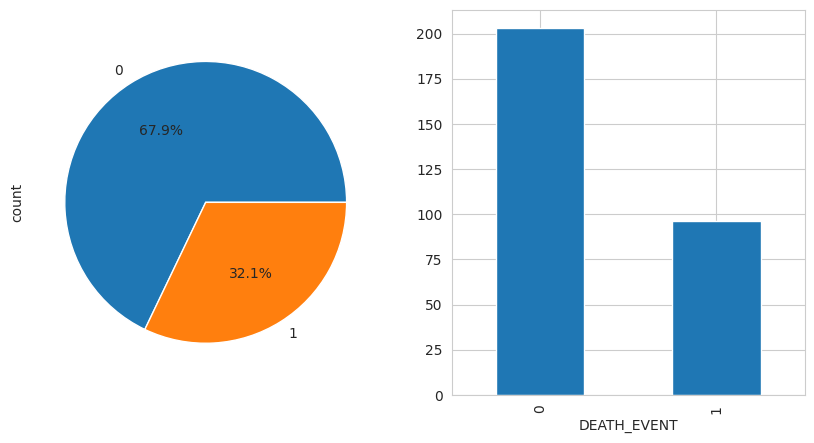

In [14]:
#target distribition pie plot & count plot yanyana çizdirme
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
df[target_feature].value_counts().plot.pie(autopct='%1.1f%%')
plt.subplot(1, 2, 2)
df[target_feature].value_counts().plot(kind='bar')

<Axes: >

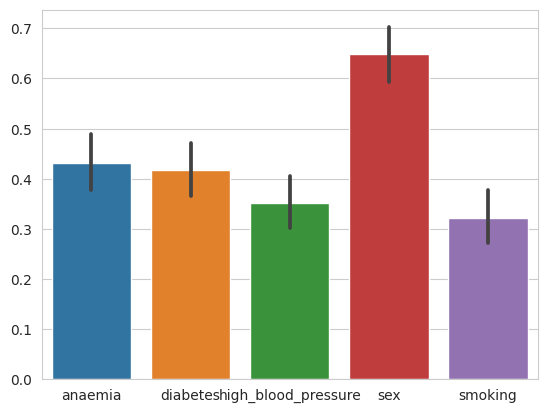

In [15]:
sns.barplot(df[categorical_features])

In [16]:
numerical_df= df.drop(categorical_features, axis=1)
corr = numerical_df.corr()[target_feature].sort_values(ascending=False)
corr

DEATH_EVENT                 1.000000
serum_creatinine            0.294278
age                         0.253729
creatinine_phosphokinase    0.062728
platelets                  -0.049139
serum_sodium               -0.195204
ejection_fraction          -0.268603
time                       -0.526964
Name: DEATH_EVENT, dtype: float64

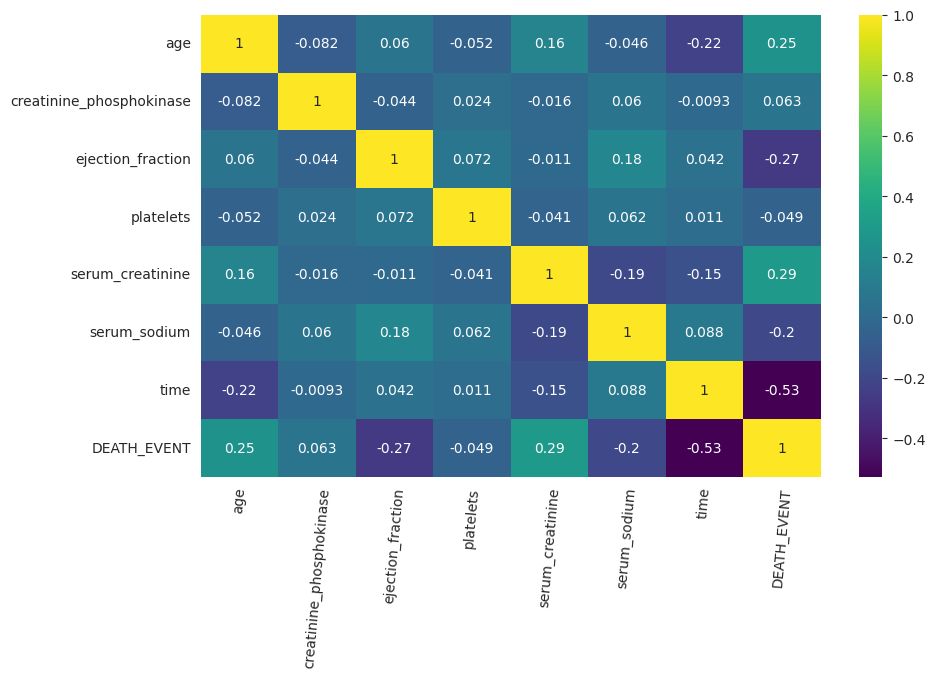

In [17]:
plot_heatmap(numerical_df)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

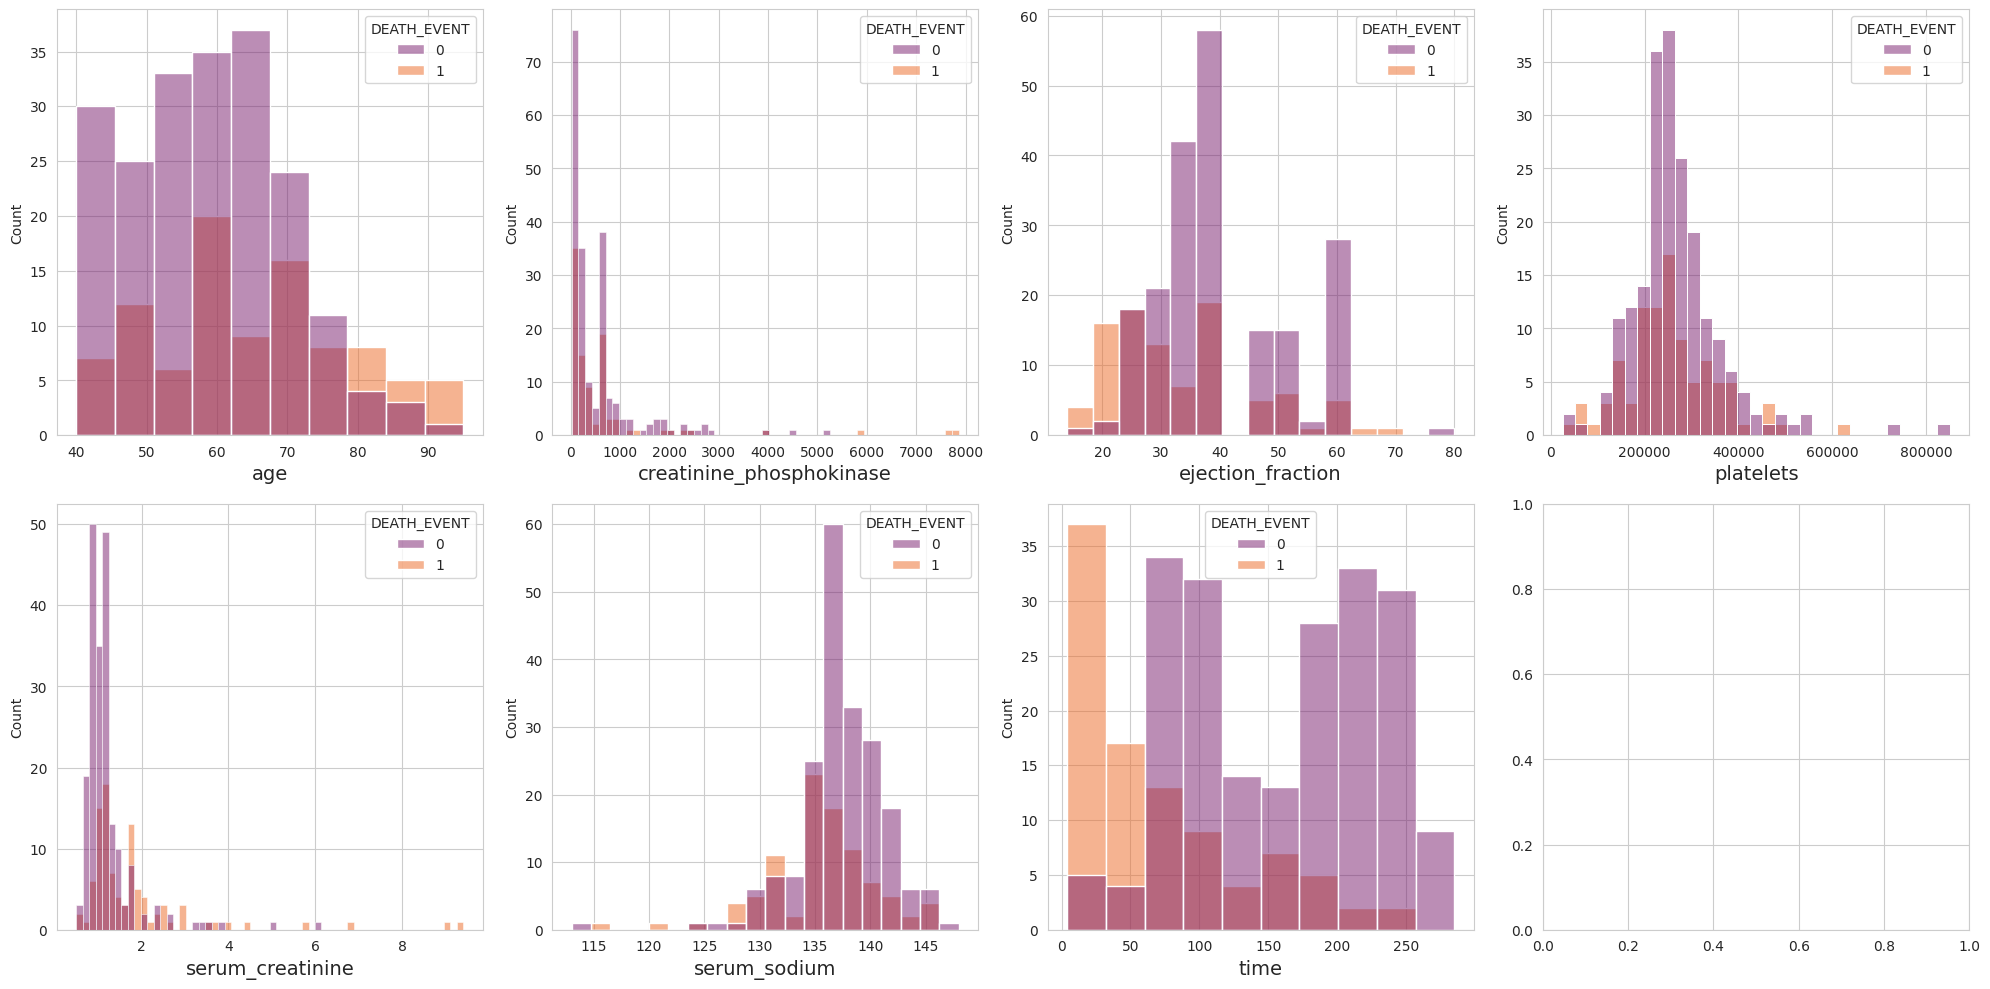

In [18]:
plot_histplot(df, numerical_features,target_feature)

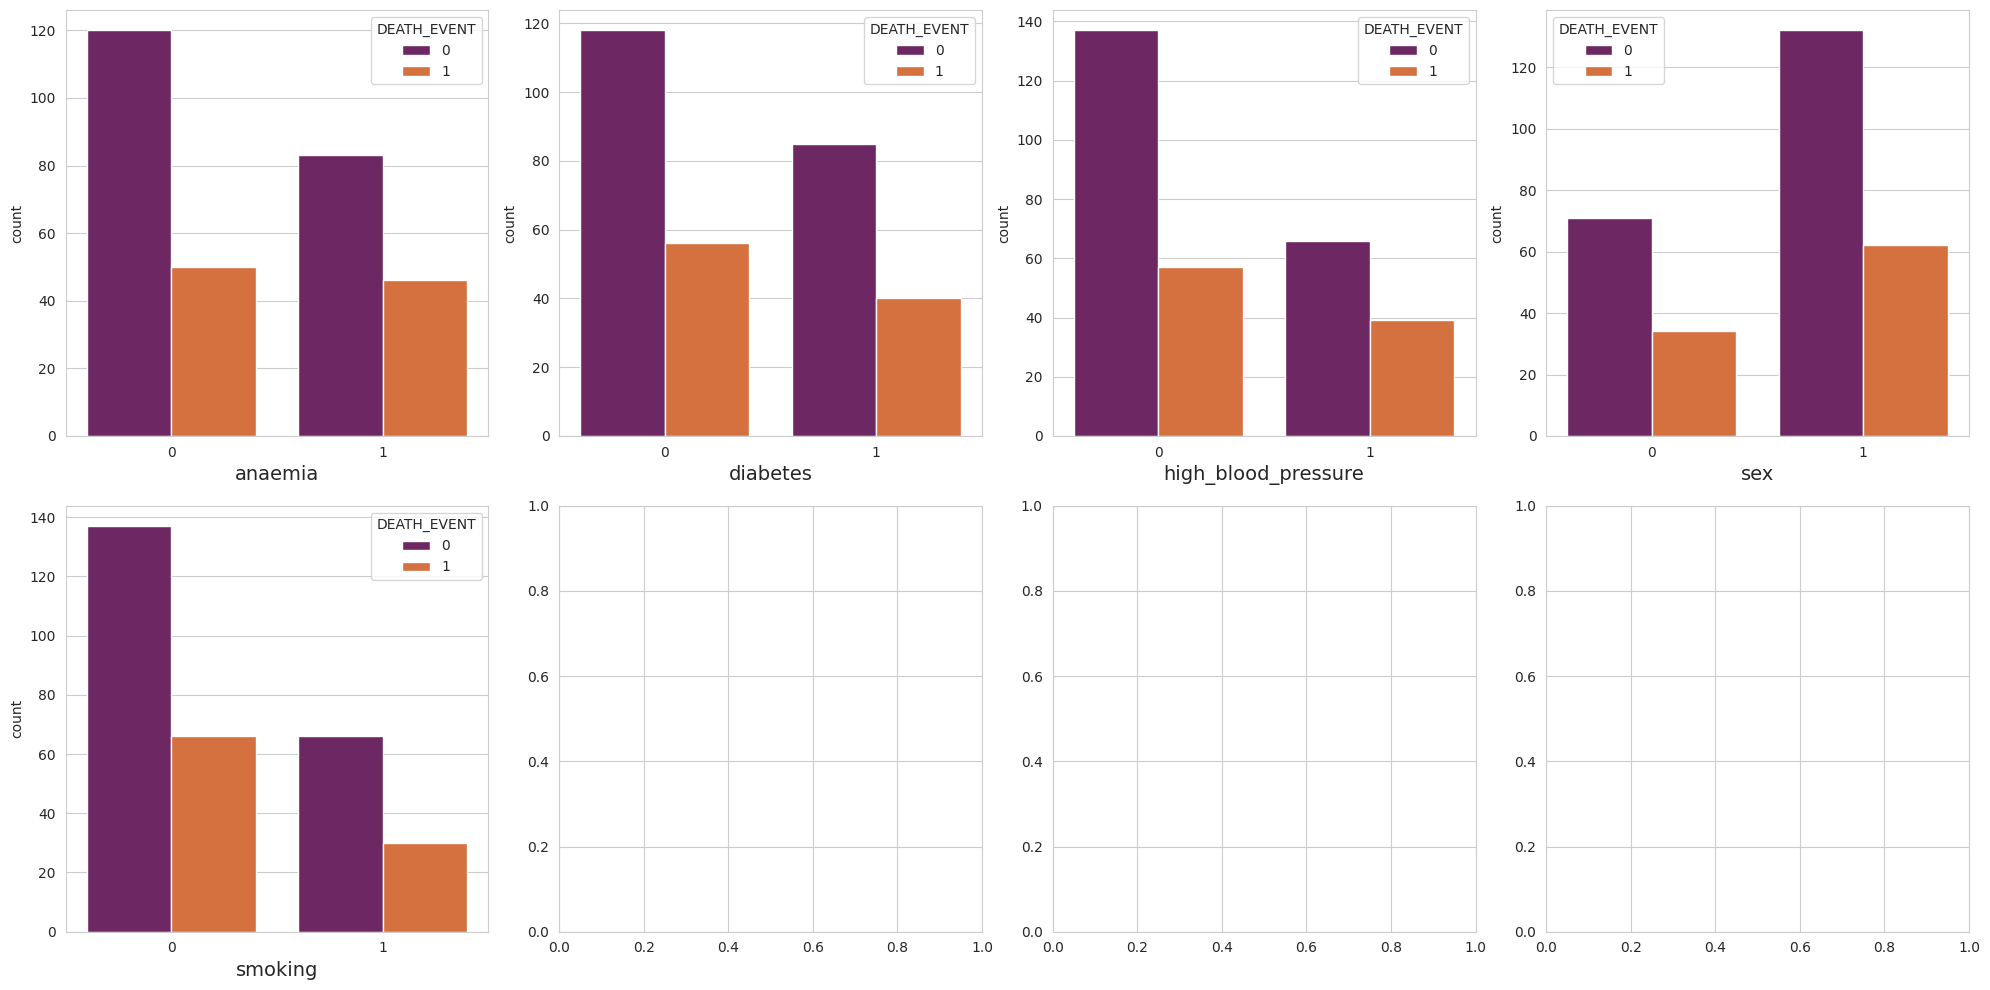

In [19]:
plot_countplot(df, categorical_features,target_feature)

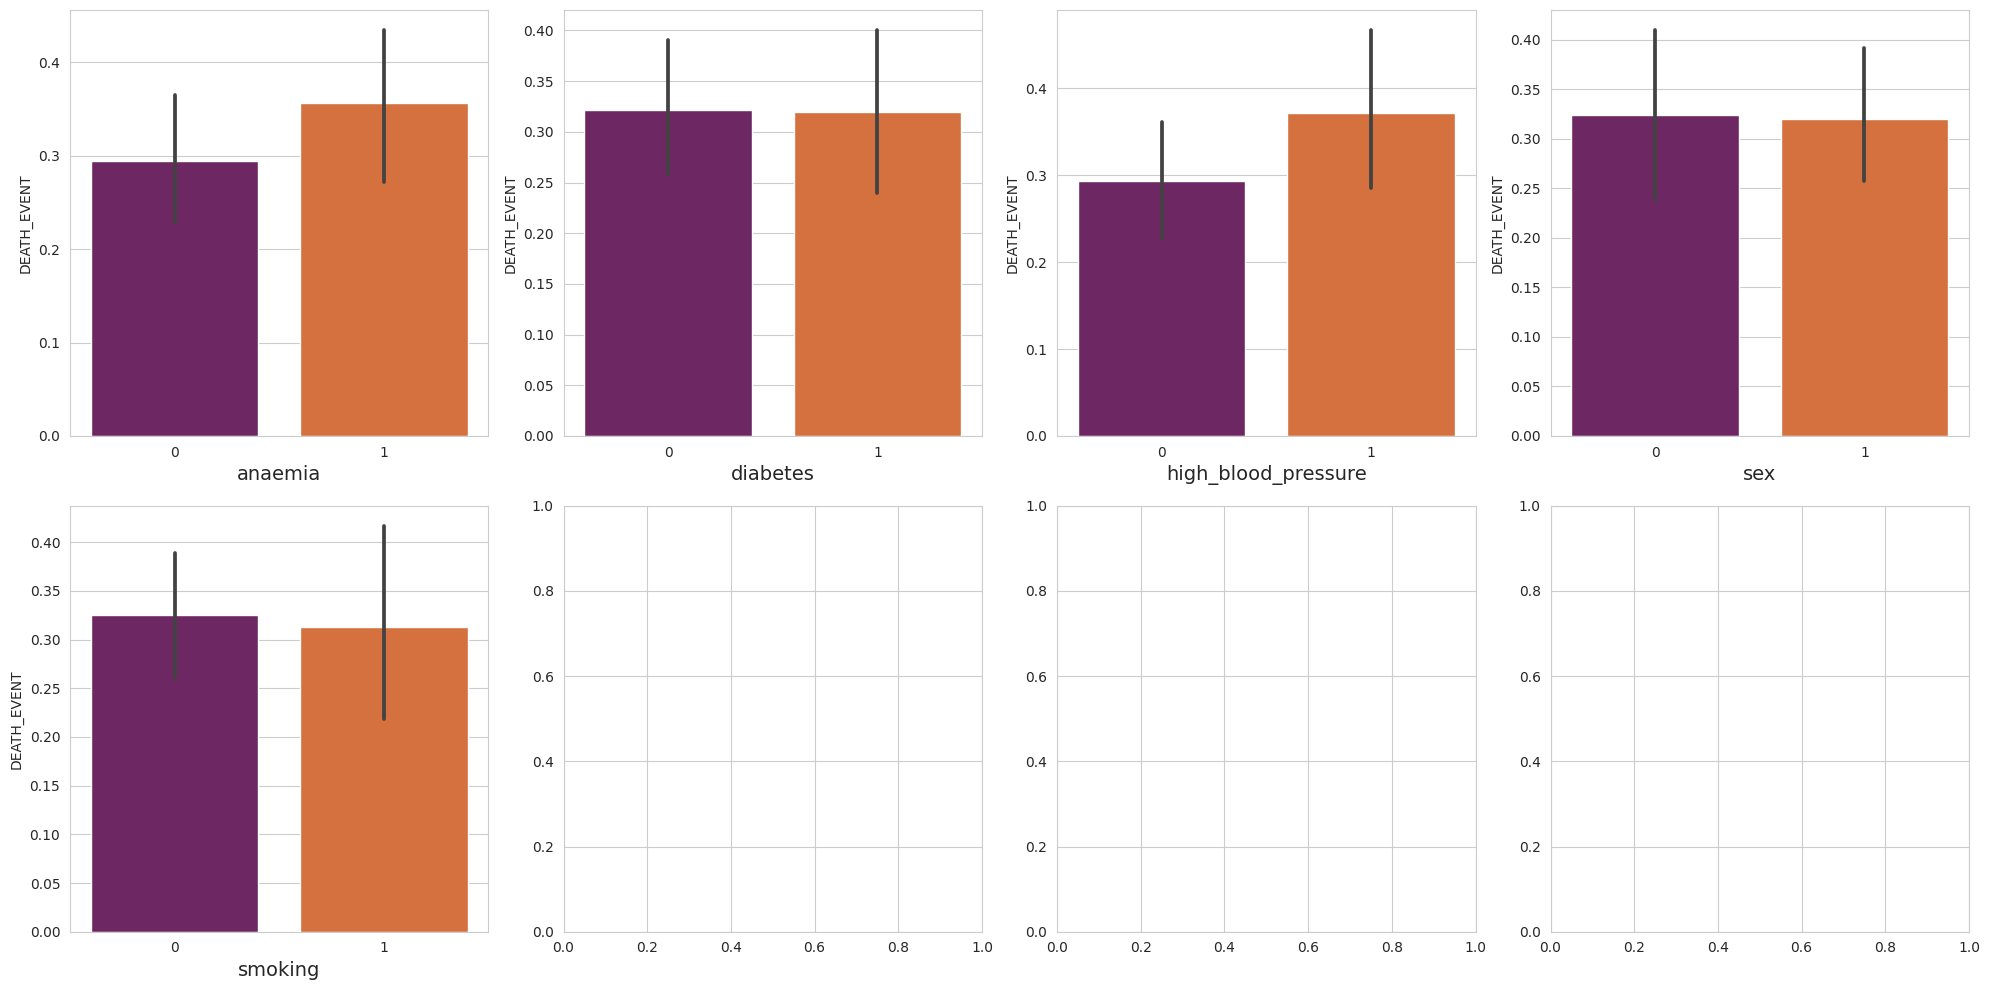

In [20]:
plot_barplot(df, categorical_features,target_feature)

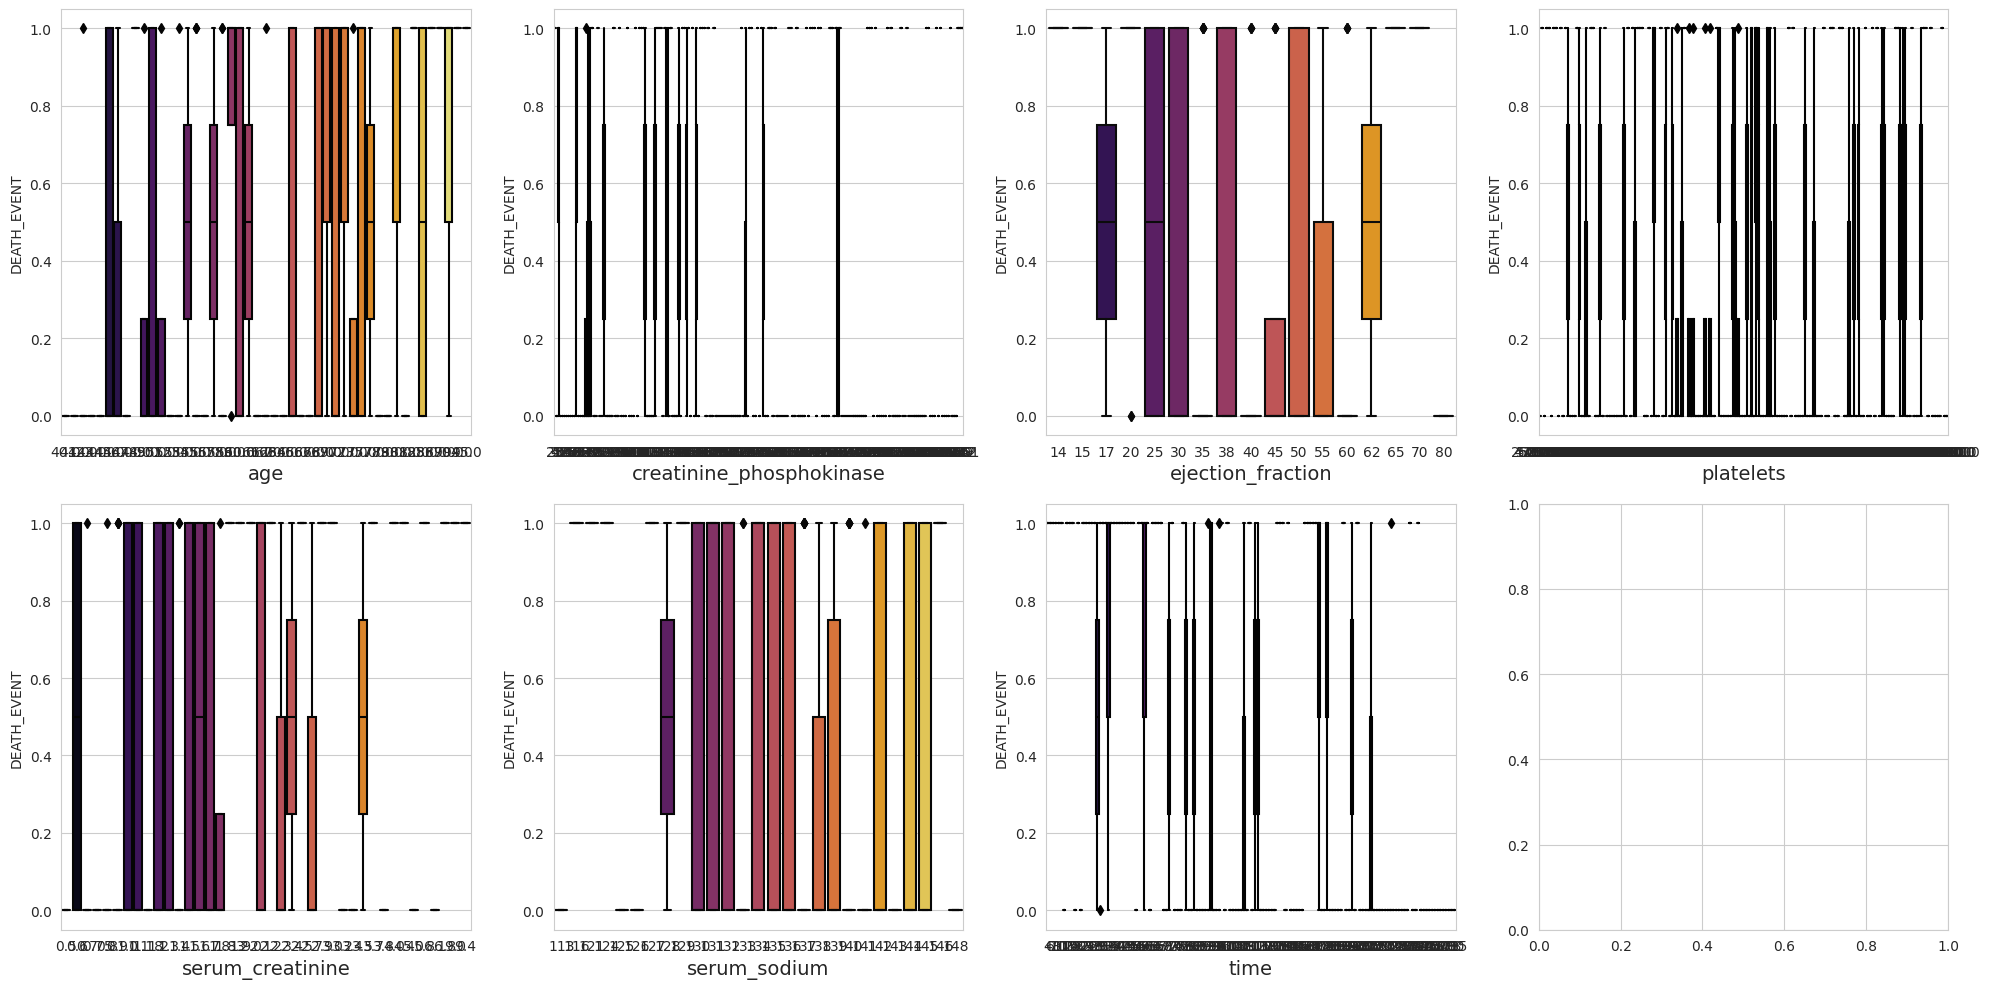

In [21]:
plot_boxplot(df, numerical_features,target_feature)

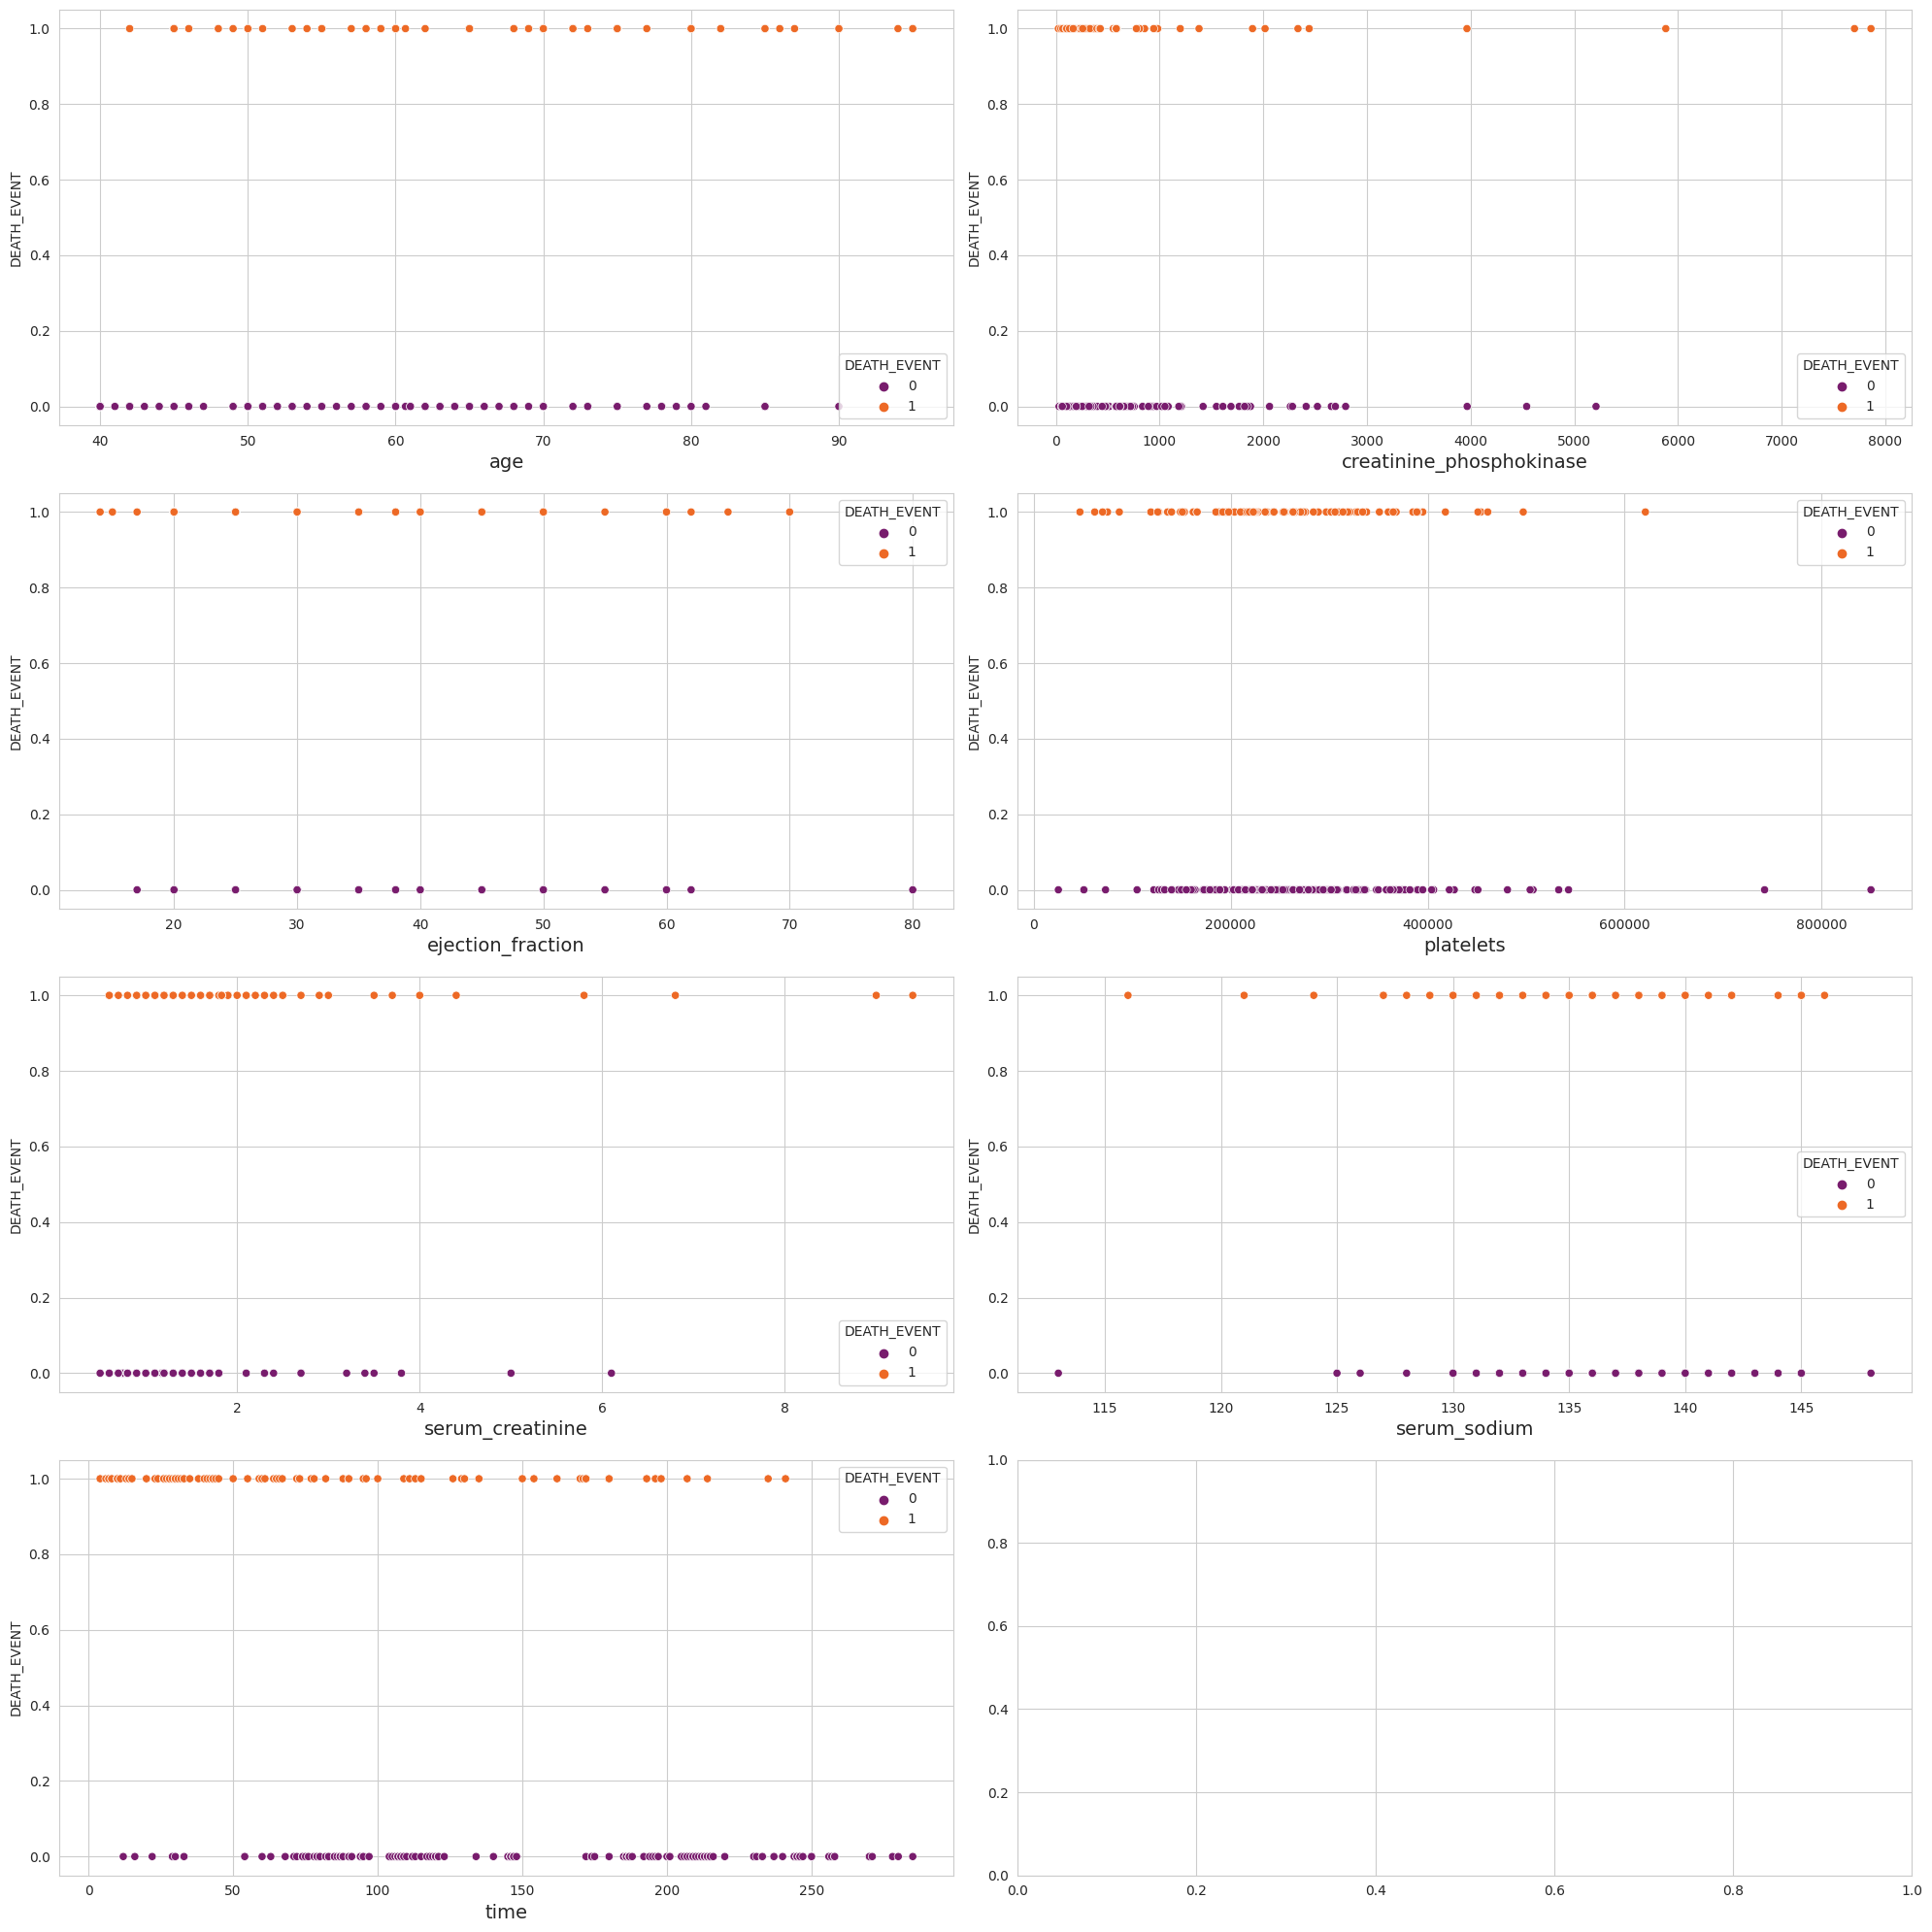

In [22]:
plot_scatterplot(df, numerical_features, target_feature )

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

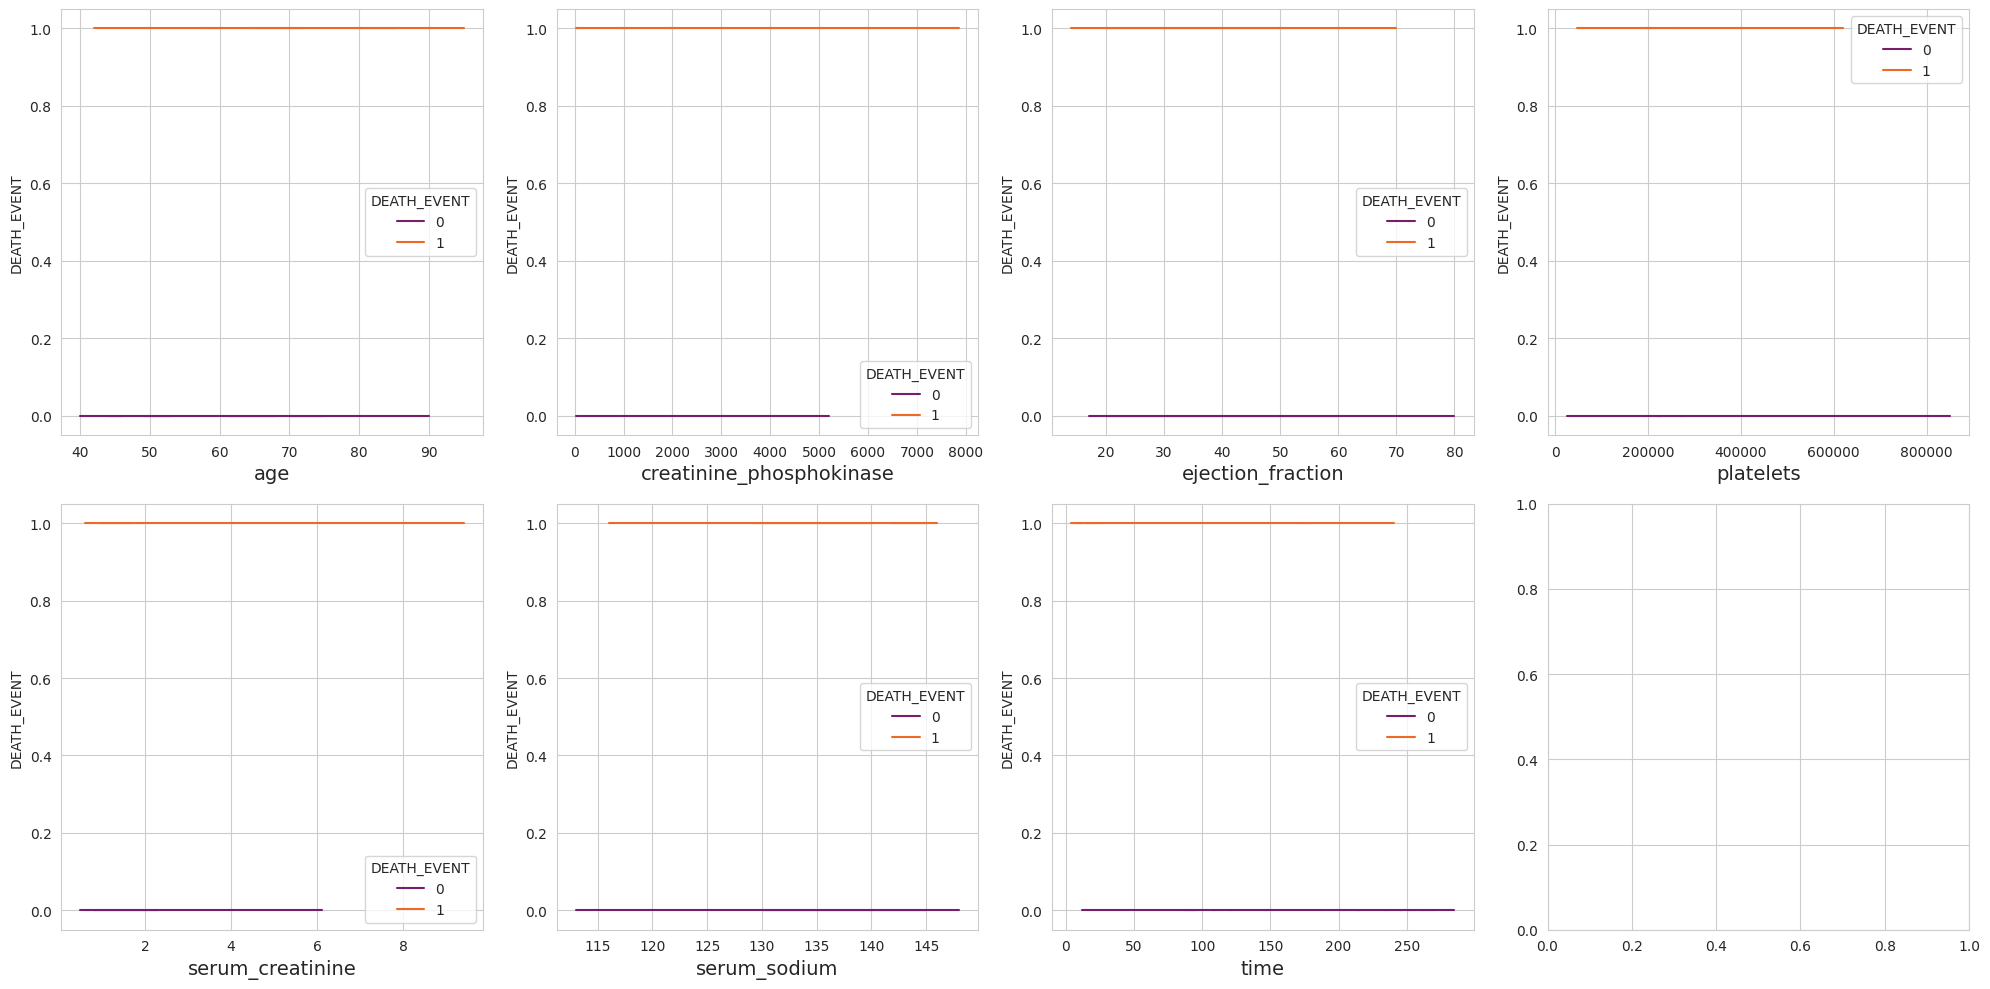

In [23]:
plot_lineplot(df, numerical_features, target_feature)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

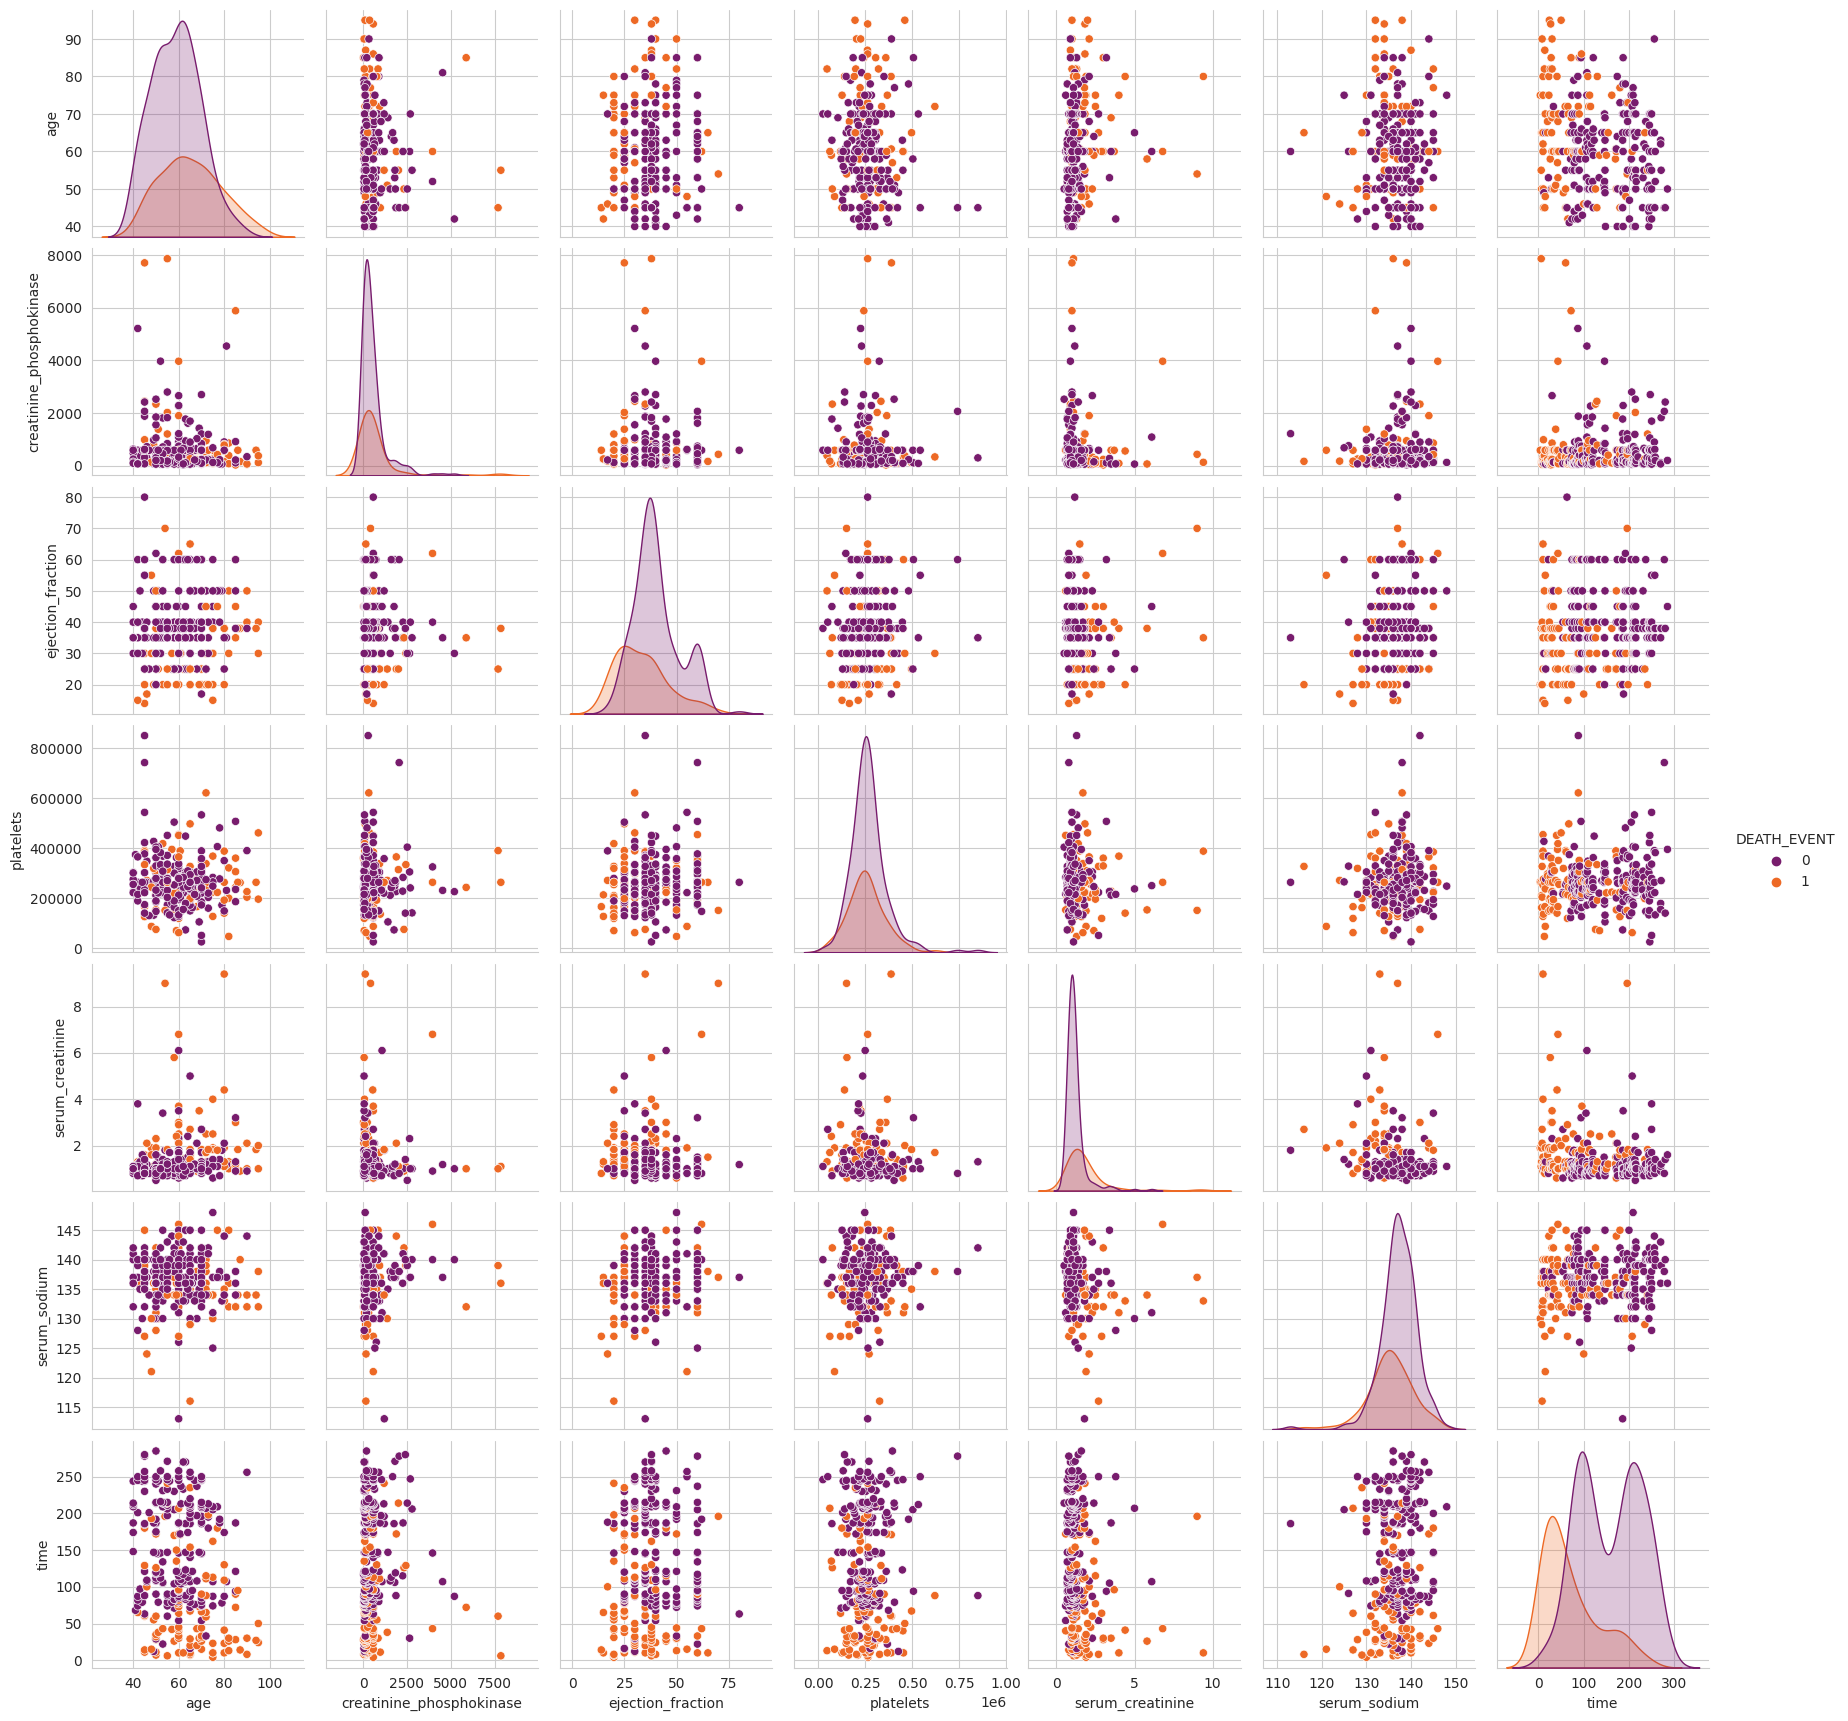

In [24]:
plot_pairplot(df  ,numerical_features,target_feature)

In [25]:
X = df.drop(columns=[target_feature], axis=1)
y = df[target_feature].values

In [26]:
X.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8


In [27]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [28]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()


for col in categorical_features:
    X[col] = le.fit_transform(X[col])
    

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier(),
    'KNN': KNeighborsClassifier(),
    #'Neural Network': MLPClassifier(),
    #'LGBM': LGBMClassifier()
}


params={
    'Logistic Regression': {'C': [0.1, 1, 10, 100], 'solver': ['liblinear'], 'max_iter': [200]},
    'Decision Tree': {'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, 7, 9, 11, 13]},
    'Random Forest': {'n_estimators': [100, 300, 500], 'max_depth': [3, 5, 7, 9, 11, 13]},
    'KNN': {'n_neighbors': [3, 5, 7, 9 , 13], 'weights': ['uniform', 'distance']},
    'Naive Bayes': { 'var_smoothing': [1e-9, 1e-8, 1e-7]},
    'Neural Network': {'hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100)], 
                       'activation': ['logistic', 'tanh', 'relu'],
                       'solver': ['adam'], 'alpha': [0.0001, 0.001, 0.01],
                       'max_iter': [ 500, 1000,2000]},
    'XGBoost': {'n_estimators': [100, 300, 500], 'max_depth': [3, 5, 7, 9, 11, 13]},
    'LGBM': {'n_estimators': [100, 300, 500], 'max_depth': [3, 5, 7, 9, 11, 13]}
}

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score , f1_score ,classification_report

# Train function
def train_model(X_train, y_train, models, params):
    best_estimators = {}
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=params[model_name],
            scoring='accuracy',
            cv=5, n_jobs=-1
        )
        
        grid_search.fit(X_train, y_train)
        best_estimators[model_name] = grid_search.best_estimator_
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        print(f"Best score for {model_name}: {grid_search.best_score_}\n")
    return best_estimators

# Evaluate function
def evaluate_model(X_test, y_test, models):
    classification_reports = {}

    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

       

        classification_rep = classification_report(y_test, y_pred)

       

        classification_reports[model_name] = classification_rep

    return  classification_reports

In [33]:
# Train the models
best_models = train_model(X_train, y_train, models, params)


Training Logistic Regression...
Best parameters for Logistic Regression: {'C': 1, 'max_iter': 200, 'solver': 'liblinear'}
Best score for Logistic Regression: 0.836436170212766

Training Decision Tree...
Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 5}
Best score for Decision Tree: 0.8495567375886525

Training Random Forest...
Best parameters for Random Forest: {'max_depth': 11, 'n_estimators': 300}
Best score for Random Forest: 0.8913120567375886

Training Naive Bayes...
Best parameters for Naive Bayes: {'var_smoothing': 1e-09}
Best score for Naive Bayes: 0.7823581560283689

Training XGBoost...
Best parameters for XGBoost: {'max_depth': 3, 'n_estimators': 500}
Best score for XGBoost: 0.874645390070922

Training KNN...
Best parameters for KNN: {'n_neighbors': 7, 'weights': 'uniform'}
Best score for KNN: 0.7656028368794326



In [34]:
# Evaluate the best models
classification_reports = evaluate_model(X_test, y_test, best_models)


Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating Random Forest...
Evaluating Naive Bayes...
Evaluating XGBoost...
Evaluating KNN...


In [35]:
# Print classification reports
for model_name, report in classification_reports.items():
    print(f"\nClassification Report for {model_name}:\n{report}")


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.77      0.97      0.86        35
           1       0.94      0.60      0.73        25

    accuracy                           0.82        60
   macro avg       0.86      0.79      0.80        60
weighted avg       0.84      0.82      0.81        60


Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.70      0.89      0.78        35
           1       0.75      0.48      0.59        25

    accuracy                           0.72        60
   macro avg       0.73      0.68      0.69        60
weighted avg       0.72      0.72      0.70        60


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.70      0.94      0.80        35
           1       0.85      0.44      0.58        25

    accuracy                           0.73       